<a href="https://colab.research.google.com/github/aaaraafaat/ML--Learning_Base/blob/main/ML_TS_Forecasting_Nottem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

In [3]:
# --- STEP 1: DATA LOADING AND INITIAL ANALYSIS ---

# Load the Nottingham temperature dataset.
file_path = "nottem.csv"
data = pd.read_csv('https://raw.githubusercontent.com/aaaraafaat/ML--Learning_Base/refs/heads/main/nottem.csv')

# Rename the 'nottem' column to 'Value' for consistency.
data.rename(columns={'nottem': 'Value'}, inplace=True)

# Create a proper monthly date index for the data, as the original 'time' column is in decimal years.
# The data starts from January 1920.
date_index = pd.date_range(start='1920-01', periods=len(data), freq='M')
data.index = date_index
data = data['Value']

/tmp/ipython-input-940740030.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_index = pd.date_range(start='1920-01', periods=len(data), freq='M')


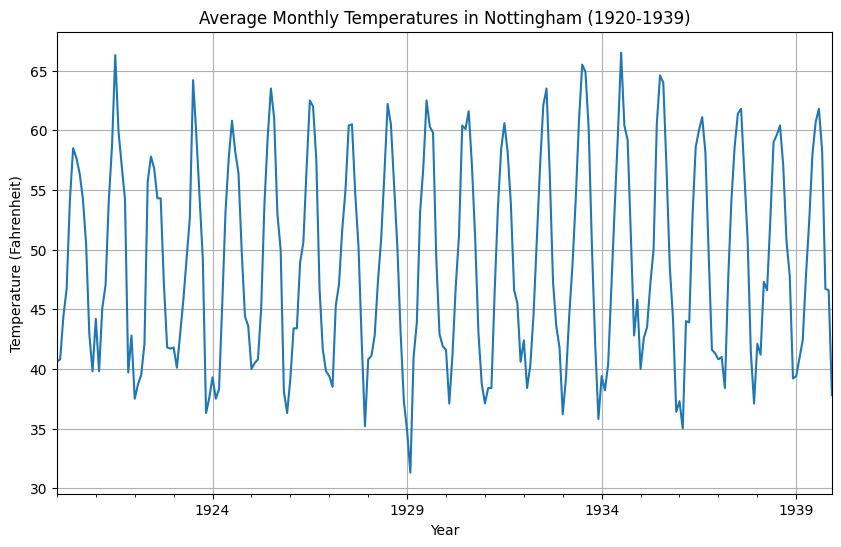

In [4]:
# Visualize the time series data to observe its characteristics.
plt.figure(figsize=(10, 6))
data.plot()
plt.title("Average Monthly Temperatures in Nottingham (1920-1939)")
plt.xlabel("Year")
plt.ylabel("Temperature (Fahrenheit)")
plt.grid(True)
plt.show()

In [5]:
# --- STEP 2: DATA PREPROCESSING ---

# Scale the data to a range of [0, 1].
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

# Define a function to convert the time series into a supervised learning format.
def create_lagged_data(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

# Set the lag value to 12. Since the data is monthly and has a clear yearly
# seasonal pattern, a lag of 12 allows the model to learn from a full year's cycle.
lag = 12
X, y = create_lagged_data(data_scaled, lag)

# Reshape the input data for RNNs.
X = X.reshape(X.shape[0], X.shape[1], 1)

In [6]:
# --- STEP 3: TRAIN-TEST SPLIT ---

# Split the dataset into training and testing sets.
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [ ]:
# --- STEP 4 & 5: MODEL TRAINING, PREDICTION, AND EVALUATION ---
# This section trains all five models and finds the best one.

In [8]:
rmse_results = {}

# --- Model 1: Random Forest ---
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train.ravel())
y_pred_rf = rf_model.predict(X_test_rf)
rmse_results['Random Forest'] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# --- Model 2: Support Vector Machine (SVM) ---
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_svm, y_train.ravel())
y_pred_svm = svm_model.predict(X_test_svm)
rmse_results['SVM'] = np.sqrt(mean_squared_error(y_test, y_pred_svm))

# --- Model 3: Artificial Neural Network (ANN) ---
X_train_ann = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_ann = X_test.reshape(X_test.shape[0], X_test.shape[1])
ann_model = Sequential([Dense(64, input_dim=X_train_ann.shape[1], activation='relu'), Dense(32, activation='relu'), Dense(1)])
ann_model.compile(optimizer='adam', loss='mse')
ann_model.fit(X_train_ann, y_train, epochs=100, batch_size=16, verbose=0)
y_pred_ann = ann_model.predict(X_test_ann)
rmse_results['ANN'] = np.sqrt(mean_squared_error(y_test, y_pred_ann))

# --- Model 4: Long Short-Term Memory (LSTM) ---
lstm_model = Sequential([LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)), LSTM(50), Dense(1)])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)
rmse_results['LSTM'] = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

# --- Model 5: Gated Recurrent Unit (GRU) ---
gru_model = Sequential([GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)), GRU(50), Dense(1)])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
y_pred_gru = gru_model.predict(X_test)
rmse_results['GRU'] = np.sqrt(mean_squared_error(y_test, y_pred_gru))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step


--- RMSE Comparison for Models ---
Random Forest: 0.0653
SVM: 0.0624
ANN: 0.0673
LSTM: 0.0644
GRU: 0.0656


/tmp/ipython-input-1244265671.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(rmse_results.keys()), y=list(rmse_results.values()), palette="viridis")


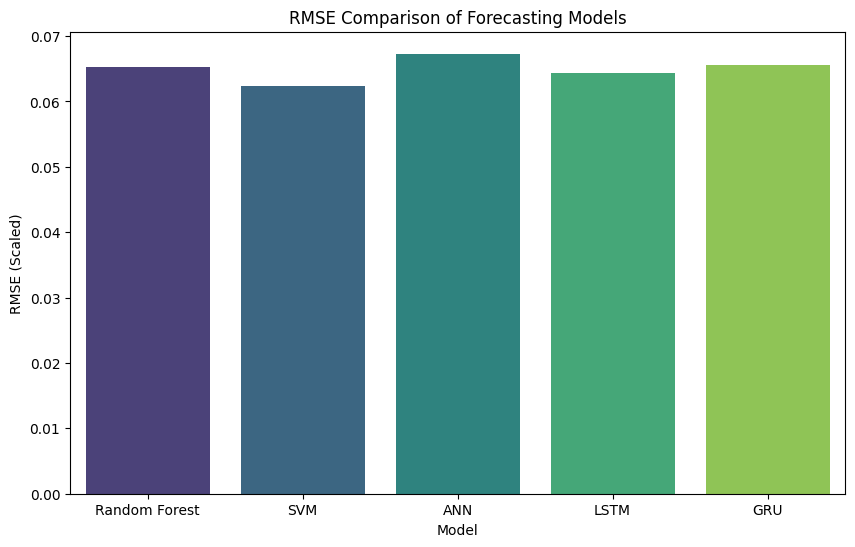

In [9]:
# --- STEP 6: RESULTS VISUALIZATION ---
# This section plots the model performance.
print("--- RMSE Comparison for Models ---")
for model, rmse in rmse_results.items():
    print(f"{model}: {rmse:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(rmse_results.keys()), y=list(rmse_results.values()), palette="viridis")
plt.title('RMSE Comparison of Forecasting Models')
plt.xlabel('Model')
plt.ylabel('RMSE (Scaled)')
plt.show()


--- Generating Forecast with Best Model: SVM ---


/tmp/ipython-input-3466102579.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='M')[1:]


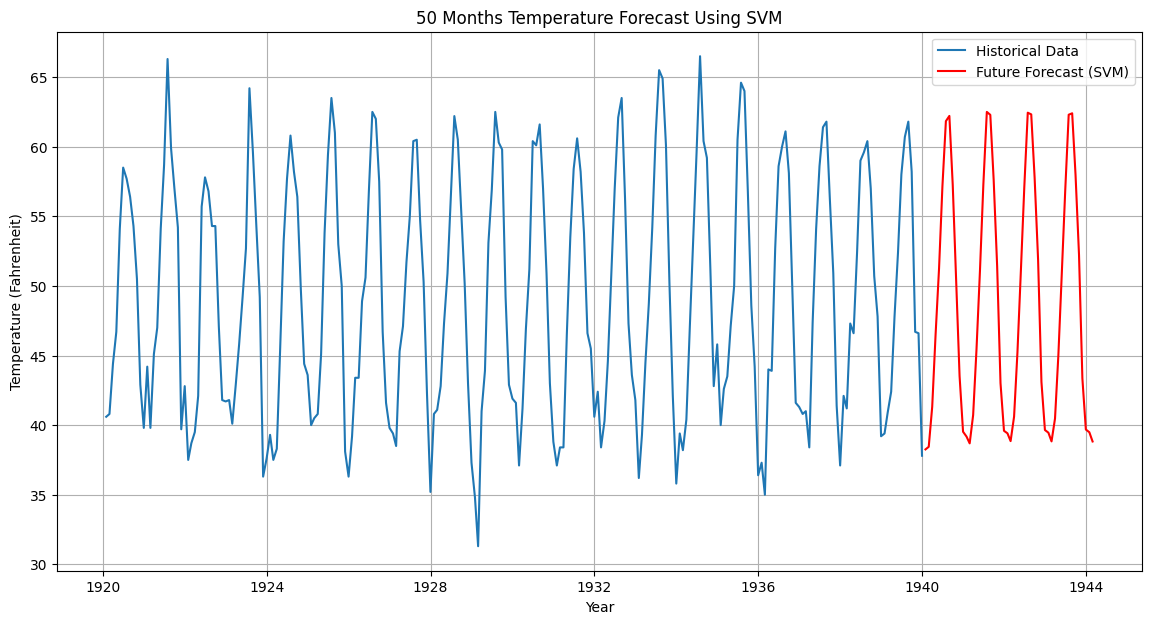

In [12]:
# --- STEP 7: FUTURE FORECASTING WITH THE BEST MODEL ---

# Identify the best model based on the lowest RMSE score.
best_model_name = min(rmse_results, key=rmse_results.get)
# Create a temporary dictionary to select the best model object by name
temp_model_dict = {
    'Random Forest': rf_model, 'SVM': svm_model, 'ANN': ann_model,
    'LSTM': lstm_model, 'GRU': gru_model
}
best_model = temp_model_dict[best_model_name]
print(f"\n--- Generating Forecast with Best Model: {best_model_name} ---")

# Set the number of future steps to forecast.
forecast_steps = 50
# Start with the last known sequence from the original data.
last_sequence = data_scaled[-lag:].reshape(1, lag, 1)
forecast_scaled = []

# Iteratively predict future steps.
for _ in range(forecast_steps):
    # Reshape input based on the best model's requirements.
    if best_model_name in ['LSTM', 'GRU']:
        input_seq = last_sequence
    else: # RF, SVM, ANN
        input_seq = last_sequence.reshape(1, lag)

    # Predict the next time step.
    next_pred_scaled = best_model.predict(input_seq)[0]
    # Ensure the prediction is a single scalar value.
    if isinstance(next_pred_scaled, np.ndarray):
        next_pred_scaled = next_pred_scaled[0]

    forecast_scaled.append(next_pred_scaled)

    # Update the sequence: remove the oldest value and append the new prediction.
    new_sequence = np.append(last_sequence.flatten()[1:], next_pred_scaled)
    last_sequence = new_sequence.reshape(1, lag, 1)

# Inverse transform the forecasted values back to the original scale.
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# Create a date range for the future forecast period.
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='M')[1:]

# Plot the original historical data along with the new forecast.
plt.figure(figsize=(14, 7))
plt.plot(data.index, data.values, label='Historical Data')
plt.plot(future_dates, forecast, label=f'Future Forecast ({best_model_name})', color='red')
plt.title(f'50 Months Temperature Forecast Using {best_model_name}')
plt.xlabel('Year')
plt.ylabel('Temperature (Fahrenheit)')
plt.legend()
plt.grid(True)
plt.show()



--- Generating Future Forecasts for All Models ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/ste

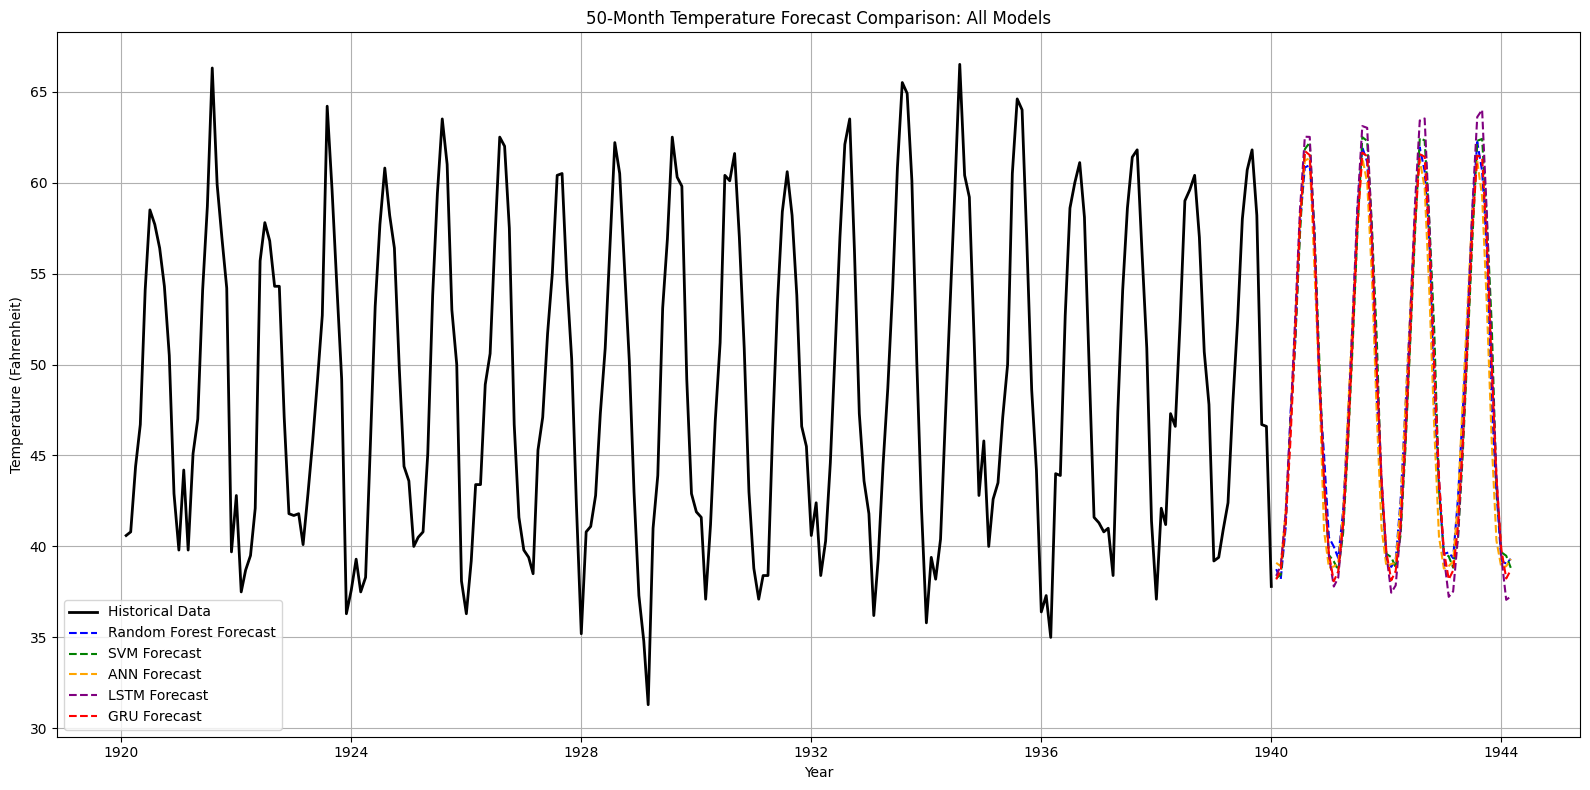

In [14]:
# --- STEP 8: FUTURE FORECAST COMPARISON FOR ALL MODELS ---

# Create a dictionary of all trained models for easy access in the forecast loop
all_models = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'ANN': ann_model,
    'LSTM': lstm_model,
    'GRU': gru_model
}

print("\n--- Generating Future Forecasts for All Models ---")
# Prepare dictionary to store forecasts for each model
forecasts = {}
# Prepare initial input sequence for forecasting
base_sequence = data_scaled[-lag:].reshape(1, lag, 1)

# Define a function to perform the iterative forecast for any given model.
def iterative_forecast(model, model_name, steps, initial_sequence, lag_size):
    seq = initial_sequence.copy()
    preds_scaled = []
    for _ in range(steps):
        # Reshape input based on model type
        if model_name in ['LSTM', 'GRU']:
            input_data = seq
        else:  # RF, SVM, ANN
            input_data = seq.reshape(1, lag_size)

        # Get prediction and ensure it's a scalar
        pred = model.predict(input_data)[0]
        if isinstance(pred, np.ndarray):
            pred = pred[0]

        preds_scaled.append(pred)

        # Update the sequence for the next prediction
        new_seq = np.append(seq.flatten()[1:], pred)
        seq = new_seq.reshape(1, lag_size, 1)

    return np.array(preds_scaled)

# Run the forecast for each model
for name, model_obj in all_models.items():
    preds_scaled = iterative_forecast(model_obj, name, forecast_steps, base_sequence, lag)
    preds_unscaled = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    forecasts[name] = preds_unscaled

# Plot historical data + all forecasts for comparison
plt.figure(figsize=(16, 8))
plt.plot(data.index, data.values, label='Historical Data', color='black', linewidth=2)

# Define colors for each model's forecast line
colors = ['blue', 'green', 'orange', 'purple', 'red']
for color, (model_name, forecast_values) in zip(colors, forecasts.items()):
    plt.plot(future_dates, forecast_values, label=f'{model_name} Forecast', color=color, linestyle='--')

plt.title('50-Month Temperature Forecast Comparison: All Models')
plt.xlabel('Year')
plt.ylabel('Temperature (Fahrenheit)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
